# Extreme Heat exposure assessment

In this notebook, we will perform an **extreme heat exposure assessment** for transportation infrastructure, specifically focusing on railways. The assessment is based on combining hazard data (e.g., occurence of extreme temperatures) with spatial information on railway infrastructure to understand how future climate could increase the impact of extreme heat on the performance of railway infrastructure.

We will follow the steps outlined below to conduct the assessment:

1. **Loading the necessary packages:**  
   We will import the Python libraries required for data handling, analysis, and visualization.

2. **Loading the data:**  
   The infrastructure data (e.g., railways) and hazard data (e.g., PGA levels) will be loaded into the notebook.

3. **Preparing the data:**  
   The infrastructure and hazard data will be processed and data gaps can be filled, if required.

4. **Performing the exposure assessment:**  
   We will overlay the railway infrastructure data with data on extreme heat.

5. **Visualizing the results:**  
   Finally, we will visualize the estimated damage using graphs and maps to illustrate the impact on railway infrastructure.

## 1. Loading the Necessary Packages
To perform the assessment, we are going to make use of several [python packages](https://docs.python.org/3/tutorial/modules.html#packages).

In case you run this in Google Colab, you will have to install the packages below **(remove the hashtag in front of them)**.

In [1]:
#!pip install damagescanner==0.9b14
#!pip install contextily
#!pip install exactextract
#!pip install lonboard

In this step, we will import all the required Python libraries for data manipulation, spatial analysis, and visualization.

In [4]:
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely
from tqdm import tqdm
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import contextily as cx

import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data
from damagescanner.base_values import DICT_CIS_VULNERABILITY_FLOOD
from statistics import mode

from lonboard import viz

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

### Specify the country of interest

Before we continue, we should specify the country for which we want to assess the damage. We use the ISO3 code for the country to download the OpenStreetMap data.

In [2]:
country_full_name = 'Angola'
country_iso3 = 'AGO'

## 2. Loading the Data
In this step, we will load four key datasets:

1. **Infrastructure data:**  
   This dataset contains information on the location and type of transportation infrastructure (e.g., roads). Each asset may have attributes such as type, length, and replacement cost.

2. **Hazard data:**  
   This dataset includes information on the hazard affecting the infrastructure (e.g., flood depth at various locations).

### Infrastructure Data

To start the analysis, we first download the OpenStreetMap data from GeoFabrik. In case of locally available data, one can load the shapefiles through **gpd.read_file()**.

In [5]:
city_path = gpd.read_file('/Users/ipshitakarmakar/Dropbox (Personal)/WB/Angola/AOI/Huambo.shp')
city_path.set_crs(epsg=4326, inplace=True)

,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,GID_3,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
0,AGO,Angola,AGO.9_1,Huambo,NA,AGO.9.5_1,Huambo,NA,AGO.9.5.1_1,Chipipa,NA,NA,Commune,Commune,NA,NA,"POLYGON ((15.8424 -12.55896, 15.84247 -12.5590..."


In [6]:
# features= gpd.read_file('/Users/ipshitakarmakar/Documents/infrastructure/mnt/city-directories/Infrastructure/Shapefiles/huambo_revised/Lines/Existing/15kv/huambo_15kv_existing_underground.shp')

In [17]:
infrastructure_path = download.get_country_geofabrik(country_iso3)

Now we load the data and read only the road data.

In [26]:
%%time
features = read_osm_data(infrastructure_path,asset_type='power')

CPU times: user 24.9 s, sys: 2.15 s, total: 27.1 s
Wall time: 25.9 s


In [7]:
# clipped_features = gpd.clip(features, city_path)
# clipped_features["object_type"] = "Cable"

In [ ]:
#not clipping to city due to the larger area needed for heatwave mapping 

SSLError: HTTPSConnectionPool(host='a.basemaps.cartocdn.com', port=443): Max retries exceeded with url: /light_all/6/33/32.png (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1010)')))

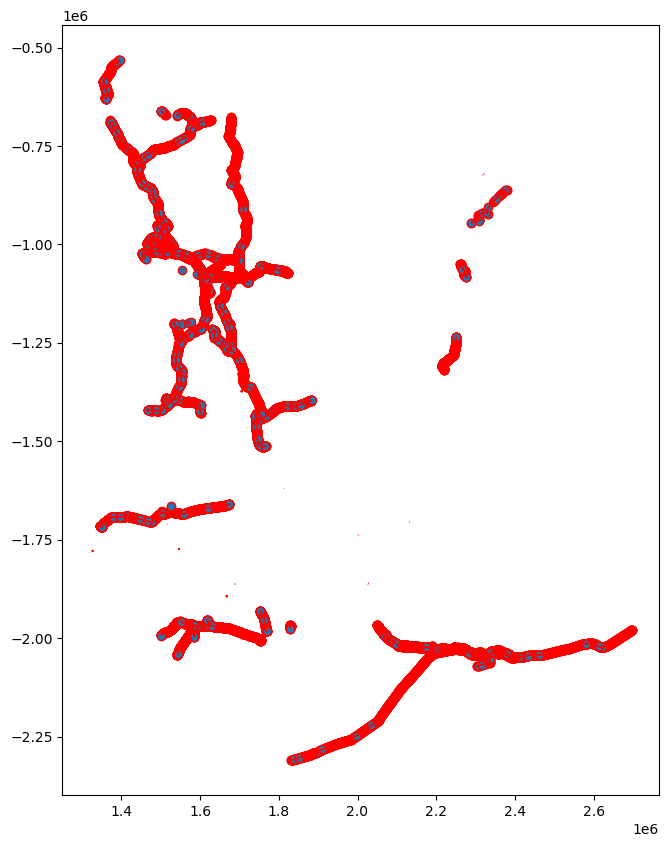

In [27]:
features_3857 = features.to_crs(epsg=3857)
# city_path_3857 = city_path.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 10))
features_3857.plot(ax=ax, edgecolor='red', facecolor='none')
# city_path_3857.plot(ax=ax, edgecolor='blue', facecolor='none', lw=2, linestyle='--')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_title('City Infrastructure')
plt.axis("off")
plt.show()

In [37]:
sub_types = clipped_features.object_type.unique()

### Hazard Data
Dealing with extreme heat is generally quite complicated. As extreme temperatures vary greatly across the world, infrastructure is also built differently for that wide range of possible temperatures. Moreover, when it comes to extreme heat, we are most interested on how climate change may change those temperature extremes. However, high-resolution climate data is very data-intensive, and it can be complicated to decide which climate model one should use for the specific region of interest. The latest set of climate projections, clustered within [CMIP-6], contains a large amount of different climate runs and climate models. All combined, they show a large possible range of futures. 

As such, we strongly suggest to look for regional or nationally-downscaled heat information to perform such an analysis. For the sake of showcasing how one could potentially assess the exposure of extreme heat on infrastructure, we show an example approach using *high resolution climate change observations and projections for the evaluation of heat-related extremes* developed by [**Williams et al., 2024](https://www.nature.com/articles/s41597-024-03074-w). The full dataset can be found [here](https://data.chc.ucsb.edu/products/CHC_CMIP6/). 

**Please note:** we require quite a lot of data-specific steps to get this analysis working. As such, different to the other hazards, this approach might be more difficult to quickly re-do with other extreme heat data.

Here we will show how to extract all data to identify how often temperature exceeded 30 degrees, and how this may change towards the future. We will exemplify this approach for **Serbia** and, as such, only grab the warmest months for **Serbia** (July and August). For different countries, one may want to select different months. Here we only select two months, as the computational time of the exposure analysis will increase substantially with each additional month added.

Let's first first select the years and months we want to consider:

In [38]:
years = [str(x) for x in np.arange(1983,2017,1)]
months = ['0'+str(x) for x in np.arange(7,9,1)]

And specify whether we want to look at 30 degrees (`30C`) or 40.6 (`40p6`) degrees plus:

In [39]:
Tmax_type = '30C'

Now we first collect the data for the historic time period. We directly clip this data to our region of interest, through taking the bounds of our **features** data.

In [40]:
collect_country_data = {}
for month in months:
    for year in tqdm(years,total=len(years),desc=month):
        file_name = f'https://data.chc.ucsb.edu/products/CHC_CMIP6/extremes/Tmax/observations/{month}/Daily_Tmax_{year}_{month}_cnt_Tmaxgt{Tmax_type}.tif'
        hazard_map = xr.open_dataset(file_name, engine="rasterio")

        collect_country_data[(month,year)]= hazard_map.rio.clip_box(minx=features.total_bounds[0],
                             miny=features.total_bounds[1],
                             maxx=features.total_bounds[2],
                             maxy=features.total_bounds[3]
                            )

08: 100%|███████████████████████████████████████| 34/34 [00:05<00:00,  5.81it/s]


And now we grab the data under **SSP5-8.5** for **2050**. One could also decide to use a different SSP scenario (**SSP2-4.5**) or a different year (**2030**). We just pick the most extreme in this example, so we can show how an extreme future climate can aggrevate the exposure. Again, we directly clip this data to our region of interest, through taking the bounds of our **features** data.

In [41]:
collect_country_data_2050_SSP585 = {}
for month in months:
    for year in tqdm(years,total=len(years),desc=month):
        file_name = f'https://data.chc.ucsb.edu/products/CHC_CMIP6/extremes/Tmax/2050_SSP585/{month}/Daily_Tmax_{year}_{month}_cnt_Tmaxgt{Tmax_type}.tif'
        hazard_map = xr.open_dataset(file_name, engine="rasterio")

        collect_country_data_2050_SSP585[(month,year)]= hazard_map.rio.clip_box(minx=features.total_bounds[0],
                             miny=features.total_bounds[1],
                             maxx=features.total_bounds[2],
                             maxy=features.total_bounds[3]
                            )

08: 100%|███████████████████████████████████████| 34/34 [00:14<00:00,  2.35it/s]


### Ancilliary data for processing

In [42]:
world = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_0_countries.shp")
world_plot = world.to_crs(3857)

In [43]:
admin1 = gpd.read_file("https://github.com/nvkelso/natural-earth-vector/raw/master/10m_cultural/ne_10m_admin_1_states_provinces.shp")

## 3. Exposure analysis
Given the complexity of defining the damage of objects to extreme heat, we focus on performing an exposure analysis within this example. 

We will first run the exposure analysis for the historical observation, followed by the future climate. This exposure assessment can take quite some time, as we have to overlay exposure hazard information for each year (*34 times*) for each month.

In [44]:
collect_exposure_historic = []
for month in months:
    for year in tqdm(years,total=len(years),desc=month):
        country_hazard_data = collect_country_data[(month,year)]
        exposed_features = DamageScanner(country_hazard_data, features, pd.DataFrame(), pd.DataFrame()).exposure(disable_progress=True)#'values']
        exposed_features['max_exposure'] = exposed_features.apply(
            lambda feature: np.max([x for x in feature['values']]), axis=1
        )
        exposed_features = exposed_features.rename(columns={'max_exposure': (month,year)})
        collect_exposure_historic.append(exposed_features[(month,year)])

08: 100%|███████████████████████████████████████| 34/34 [05:40<00:00, 10.01s/it]


In [45]:
df_baseline = pd.concat(collect_exposure_historic,axis=1).groupby(level=1,axis=1).sum()

And the future exposure analysis.

In [46]:
collect_exposure_2050_SSP585 = []
for month in months:
    for year in tqdm(years,total=len(years),desc=month):
        country_hazard_data = collect_country_data_2050_SSP585[(month,year)]
        exposed_features = DamageScanner(country_hazard_data, features, pd.DataFrame(), pd.DataFrame()).exposure(disable_progress=True)#'values']
        exposed_features['max_exposure'] = exposed_features.apply(
            lambda feature: np.max([x for x in feature['values']]), axis=1
        )
        exposed_features = exposed_features.rename(columns={'max_exposure': (month,year)})
        collect_exposure_2050_SSP585.append(exposed_features[(month,year)])

08: 100%|███████████████████████████████████████| 34/34 [06:28<00:00, 11.42s/it]


In [47]:
df_future = pd.concat(collect_exposure_2050_SSP585,axis=1).groupby(level=1,axis=1).sum()

## 4. Save the Results
For further analysis, we can save the results in their full detail, or save summary estimates per subnational unit. We show how to do this using the damage results.

In [48]:
features.merge(df_baseline,left_index=True,right_index=True).to_file(f'Power_historic_heat_exposure_{country_full_name}.gpkg')

In [49]:
features.merge(df_future,left_index=True,right_index=True).to_file(f'Power_SSP585_2050_heat_exposure_{country_full_name}.gpkg')

## 5. Visualizing the Results
The results of the exposure assessment can be visualized using charts and maps. 

Please not that future climate conditions are forced on the historical timeseries. As such, while they both show results from 1983 to 2017, the SSP5-8.5 results show how those historic conditions would worsen under future climate conditions in 2050. 

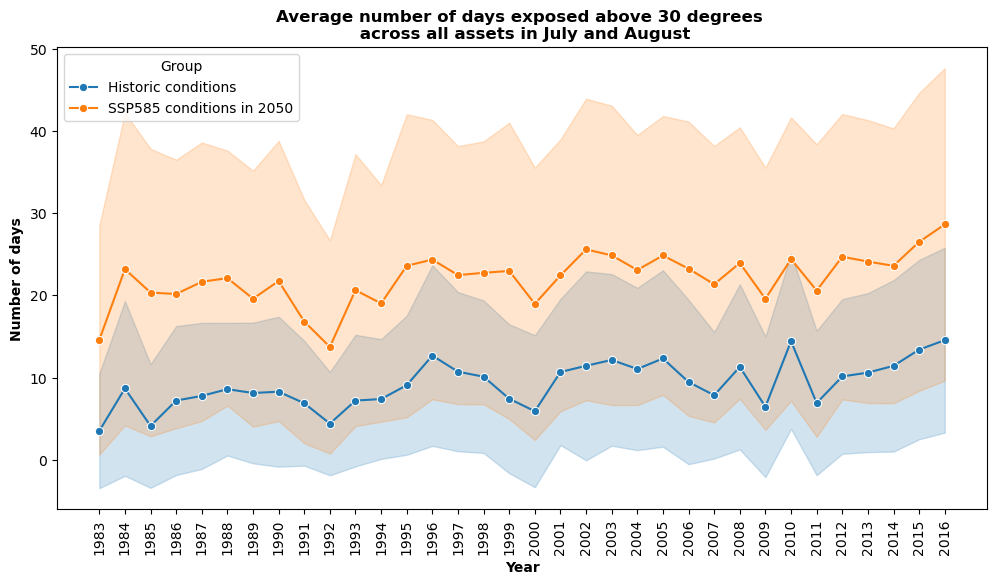

In [50]:
# Convert df_baseline to long format and add a group identifier
df_baseline_long = df_baseline.melt(var_name='Year', value_name='Value')
df_baseline_long['Year'] = df_baseline_long['Year'].astype(int)
df_baseline_long['Group'] = 'Historic conditions'

# Convert df_future to long format and add a group identifier
df_future_long = df_future.melt(var_name='Year', value_name='Value')
df_future_long['Year'] = df_future_long['Year'].astype(int)
df_future_long['Group'] = 'SSP585 conditions in 2050'

# Concatenate the two long dataframes
df_combined = pd.concat([df_baseline_long, df_future_long], axis=0)

# Define a color palette for the two groups
palette = {
    'Historic conditions': '#1f77b4',  # blue-ish
    'SSP585 conditions in 2050': '#ff7f0e'  # orange-ish
}

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Value', hue='Group', data=df_combined, ci='sd', marker='o', palette=palette)
plt.title('Average number of days exposed above 30 degrees \n across all assets in July and August', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Number of days', fontweight='bold')

# Ensure the x-axis shows all years and rotates labels 90 degrees
min_year = df_combined['Year'].min()
max_year = df_combined['Year'].max()
all_years = range(min_year, max_year + 1)
plt.xticks(all_years, rotation=90)

plt.show()


### Spatial visualisation
To gain a better understanding how extreme heat affects the assets, we will create a multi-plot, in which we visualise the absolute and relative increase in days above 30 degrees.

In [52]:
relative_increase = ((df_future-df_baseline)/df_baseline)*100
relative_increase = pd.DataFrame(relative_increase.mean(axis=1)).rename(columns = {0:'mean_increase'})
all_features_exposed = features.merge(relative_increase,left_index=True,right_index=True)

In [53]:
all_features_exposed['abs_increase'] = (df_future-df_baseline).mean(axis=1).values

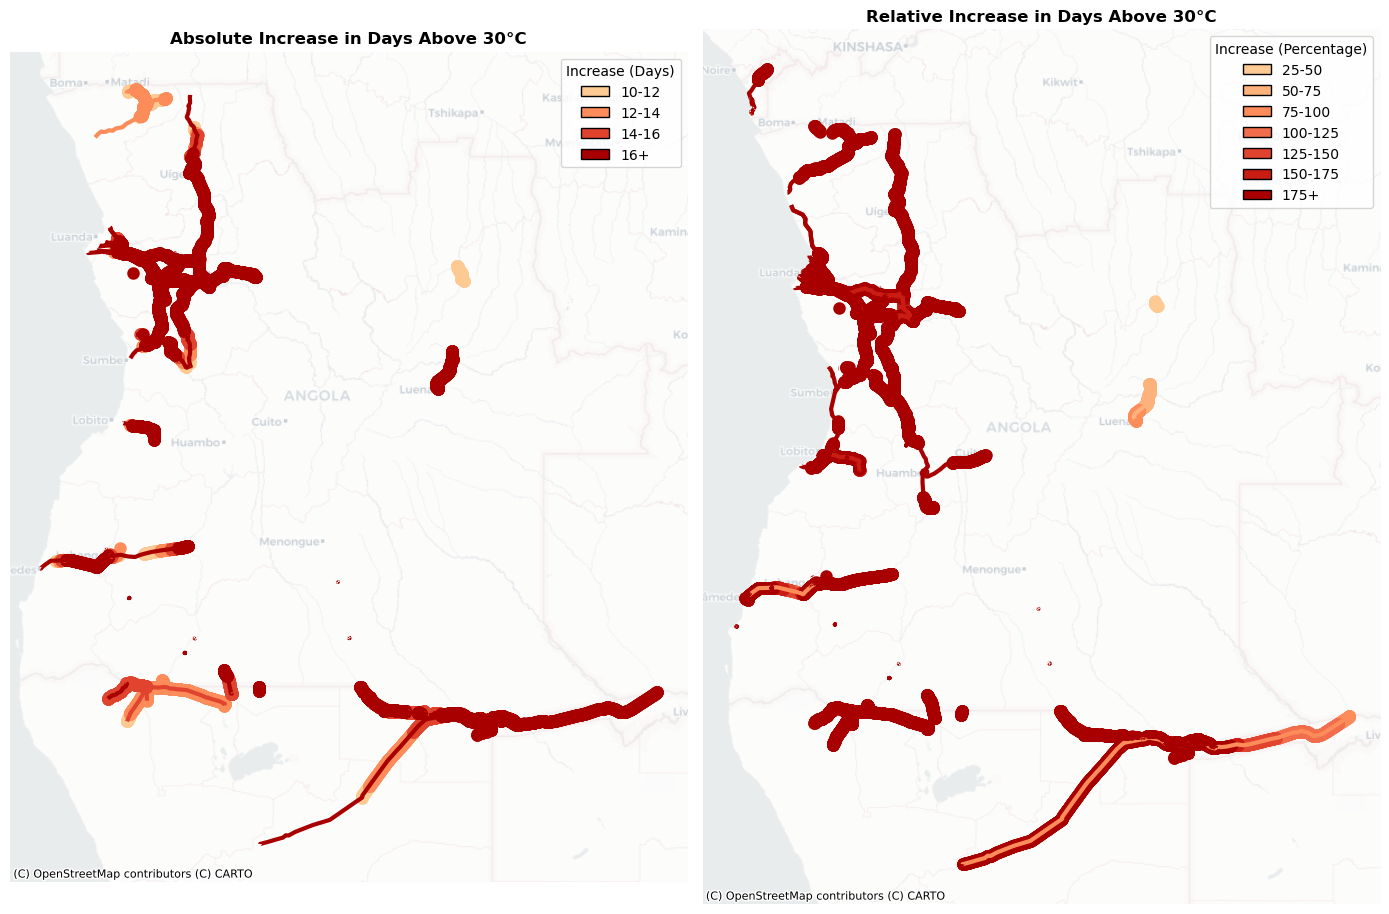

In [54]:
# Ensure that all_features_exposed is in EPSG:3857 for proper basemap overlay
if all_features_exposed.crs.to_string() != 'EPSG:3857':
    all_features_exposed = all_features_exposed.to_crs(epsg=3857)

# ---------------------------------
# Left Panel: Binned Absolute Increase
# ---------------------------------
# Define bins for absolute increase between 10 and 16.
# Values between 10-12, 12-14, 14-16, and above 16.
abs_bins = [10, 12, 14, 16, np.inf]
abs_labels = ['10-12', '12-14', '14-16', '16+']
all_features_exposed['abs_inc_cat'] = pd.cut(
    all_features_exposed['abs_increase'],
    bins=abs_bins,
    labels=abs_labels,
    include_lowest=True
)

# Create a discrete colormap for the abs_increase bins using a Blues palette.
n_abs = len(abs_labels)
abs_cmap = ListedColormap(plt.cm.OrRd(np.linspace(0.3, 0.9, n_abs)))
abs_cat_to_color = {label: abs_cmap.colors[i] for i, label in enumerate(abs_labels)}

# ---------------------------------
# Right Panel: Classified Mean Increase
# ---------------------------------
# Define classification bins for mean_increase from 25 to 175, with a final bin for >=175.
mean_bins = [25, 50, 75, 100, 125, 150, 175, np.inf]
mean_labels = ['25-50', '50-75', '75-100', '100-125', '125-150', '150-175', '175+']
all_features_exposed['mean_inc_cat'] = pd.cut(
    all_features_exposed['mean_increase'],
    bins=mean_bins,
    labels=mean_labels,
    include_lowest=True
)

# Create a discrete colormap for mean_increase using an OrRd palette.
n_mean = len(mean_labels)
mean_cmap = ListedColormap(plt.cm.OrRd(np.linspace(0.3, 0.9, n_mean)))
mean_cat_to_color = {label: mean_cmap.colors[i] for i, label in enumerate(mean_labels)}

# ---------------------------------
# Create the Multiplot Figure
# ---------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Left Panel: Plot the binned absolute increase
for cat in abs_labels:
    subset = all_features_exposed[all_features_exposed['abs_inc_cat'] == cat]
    if not subset.empty:
        subset.plot(ax=ax1, color=abs_cat_to_color[cat], linewidth=3, label=cat)
cx.add_basemap(ax1, source=cx.providers.CartoDB.Positron, alpha=0.5)
ax1.set_title("Absolute Increase in Days Above 30°C",fontweight='bold')
ax1.set_axis_off()
legend_handles_left = [Patch(facecolor=abs_cat_to_color[cat], edgecolor='black', label=cat) for cat in abs_labels]
ax1.legend(handles=legend_handles_left, title="Increase (Days)", loc='upper right')

# Right Panel: Plot the classified mean increase with thicker lines
for cat in mean_labels:
    subset = all_features_exposed[all_features_exposed['mean_inc_cat'] == cat]
    if not subset.empty:
        subset.plot(ax=ax2, color=mean_cat_to_color[cat], linewidth=3, label=cat)
cx.add_basemap(ax2, source=cx.providers.CartoDB.Positron, alpha=0.5)
ax2.set_title("Relative Increase in Days Above 30°C",fontweight='bold')
ax2.set_axis_off()
legend_handles_right = [Patch(facecolor=mean_cat_to_color[cat], edgecolor='black', label=cat) for cat in mean_labels]
ax2.legend(handles=legend_handles_right, title="Increase (Percentage)", loc='upper right')

plt.tight_layout()
plt.show()
